# Building Model
### 1. Importing Packages

In [20]:
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from io import StringIO
from collections import OrderedDict
from collections import Counter
from itertools import chain
from spacy import displacy
from spacy.matcher import PhraseMatcher
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

### Reading pdfs to match the keywords with our custom built keyword dictionary

In [21]:
def read_data(resume,keyword):
    df = pd.read_csv(resume)
    Keywords_dict = pd.read_csv(keyword)
    df.drop(df[df['Masters']==0].index, inplace=True)                  #Delete the rows which have Masters = 0
    df.drop(df[df['Total_Experience']>12].index, inplace=True)         #Delete the rows who have Total_Experience more than 10 years
    df['Exp_Sum'] = df['Summary'] + df['Experience']
    return df,Keywords_dict

### Phrase Matching

In [34]:
def model(df,Keywords_dict):
    stats_words = [nlp(text.lower()) for text in Keywords_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text.lower()) for text in Keywords_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text.lower()) for text in Keywords_dict['Machine Learning'].dropna(axis = 0)]
    DL_words = [nlp(text.lower()) for text in Keywords_dict['Deep Learning'].dropna(axis = 0)]
    prog_words = [nlp(text.lower()) for text in Keywords_dict['Programming Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text.lower()) for text in Keywords_dict['Data Engineering'].dropna(axis = 0)]
    
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('ProgL', None, *prog_words)
    matcher.add('DE', None, *Data_Engineering_words)
    
    df_key = pd.DataFrame(df['Candidate_Name'])
    df_key['keywords'] = ''
    for i,values in df.iterrows():
        exp_sum = df.loc[i,"Exp_Sum"] 
        exp_sum = exp_sum.lower()
        doc = nlp(exp_sum)
        matches = matcher(doc)
        d = []
        for match_id, start, end in matches:
            rule_id = nlp.vocab.strings[match_id]      
            span = doc[start : end]                    
            d.append((rule_id, span.text)) 
        keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
        df_key.loc[i,'keywords']=keywords
        keywords = ''
    return df_key

In [23]:
def splitter(s):
    return list(chain.from_iterable(s.str.split('\n')))

In [24]:
def count_subject(df_key):
    lengths = df_key['keywords'].str.split('\n').map(len)
    analysis = pd.DataFrame({'Candidate_name':np.repeat(df_key['Candidate_Name'],lengths),
                           'keywords':splitter(df_key['keywords'])})
    analysis.reset_index(drop=True,inplace=True)
    analysis[['Subject','Keywords']] = analysis.keywords.str.split(' ',1,expand=True)
    analysis['Count'] = analysis['Keywords'].str.split('(').str[1].str.split(')').str[0]
    analysis['Keywords'] = analysis['Keywords'].str.split('(').str[0]
    analysis.drop('keywords', axis=1, inplace=True)
    analysis = analysis.dropna()
    analysis.head(10)
    return analysis

### Code to count words under each category and visulaize it through Matplotlib

In [25]:
def filter_top(analysis):
    final_analysis = analysis['Keywords'].groupby([analysis['Candidate_name'], analysis['Subject']]).count().unstack()
    final_analysis['Na_count'] = final_analysis.isnull().sum(axis=1)
    final_analysis = final_analysis.sort_values(by='Na_count', ascending=True)
    final_analysis = final_analysis[final_analysis['Na_count']<=2]
    final_analysis = final_analysis.sort_values(by=['Na_count','ML','NLP','DE'], ascending=[True, False, False, False])
    final_analysis = final_analysis.drop('Na_count', axis=1).head(10)
    Candidates_data = final_analysis.copy()
    final_analysis = final_analysis.iloc[::-1]
    final_analysis.reset_index(inplace = True)
    final_analysis.fillna(0, inplace=True)        #all 6 top -desc
    new_data = final_analysis.iloc[:,1:]
    new_data.index = final_analysis['Candidate_name']
    return new_data,Candidates_data

In [26]:
def graph(new_data):
    plt.rcParams.update({'font.size': 15})
    ax = new_data.plot.barh(title="Resume keywords by category", legend=True, figsize=(25,10), stacked=True)
    labels = []
    for j in new_data.columns:
        for i in new_data.index:
            label = str(j)+": " + str(new_data.loc[i][j])
            labels.append(label)
    plt.savefig('Resume Graph.jpg')
    plt.show()

In [58]:
def show_top(Candidates_data,df):
    Candidates_data.reset_index(inplace = True)
    Candidates = pd.merge(Candidates_data['Candidate_name'], df[['Candidate_Name','Total_Experience','Linkedin_Profile','Contact_Info']], left_on='Candidate_name', right_on='Candidate_Name', how='left')
    Candidates.index = range(1,len(Candidates)+1)
    Candidates['Rank'] = Candidates.index
    Candidates = Candidates.drop('Candidate_name', axis=1)
    return Candidates

In [63]:
def main():
    resume = 'Resume_Data.csv'
    keyword = 'keywords_dict.csv'
    df,Keywords_dict = read_data(resume,keyword)
    df_key = model(df,Keywords_dict)
    analysis = count_subject(df_key)
    new_data,Candidates_data = filter_top(analysis)
#     graph(new_data)
    Candidates = show_top(Candidates_data,df)
    return Candidates
#     Candidates.to_csv('result.csv', index = False)

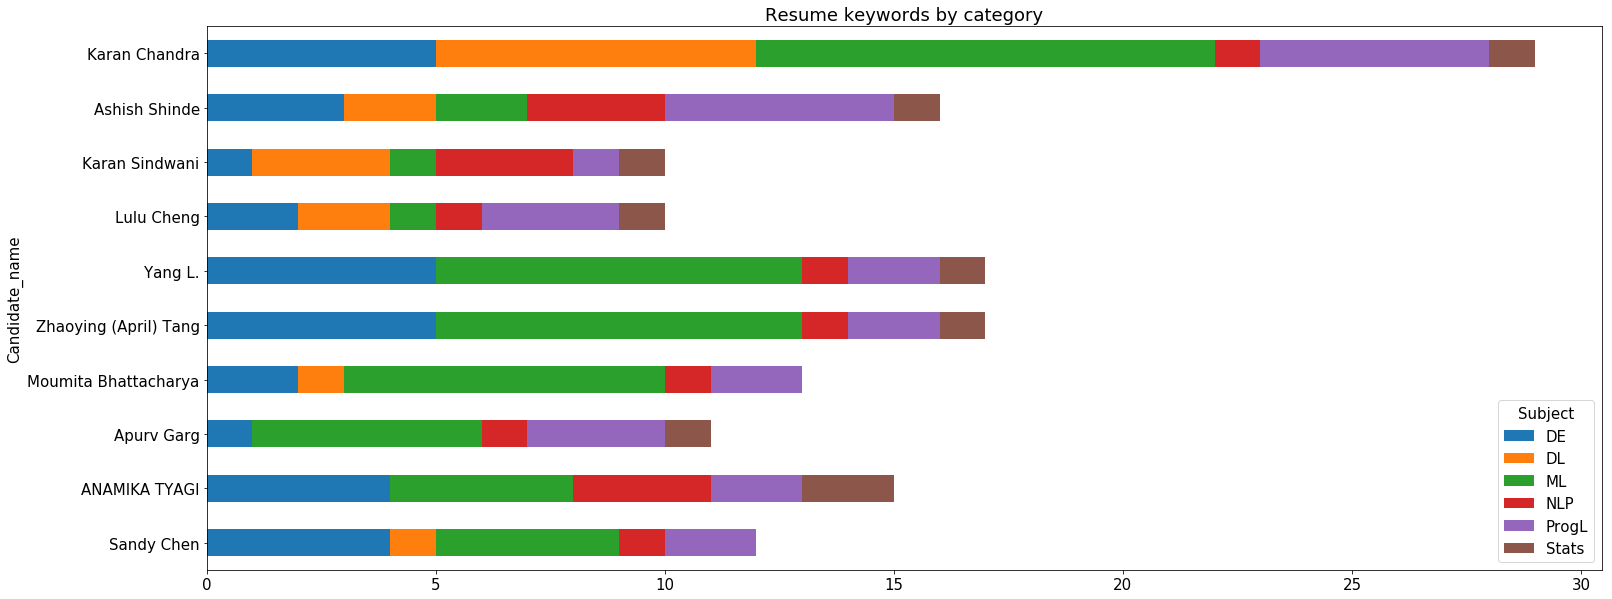

           Candidate_Name  Total_Experience  \
1           Karan Chandra              7.83   
2           Ashish Shinde              3.50   
3          Karan Sindwani              4.83   
4              Lulu Cheng              8.50   
5                 Yang L.              9.42   
6   Zhaoying (April) Tang              9.42   
7    Moumita Bhattacharya             10.42   
8              Apurv Garg              5.17   
9           ANAMIKA TYAGI              6.75   
10             Sandy Chen              0.00   

                               Linkedin_Profile             Contact_Info  Rank  
1             www.linkedin.com/in/karan-chandra  karan19031990@gmail.com     1  
2   www.linkedin.com/in/ashish-shinde-104727132       github.com/ASHIND6     2  
3             www.linkedin.com/in/karansindwani                      NaN     3  
4       www.linkedin.com/in/lulu-cheng-97193041                      NaN     4  
5               www.linkedin.com/in/apriltang63                      NaN     

In [64]:
if __name__ == '__main__':
    main()